#### Импорт необходимых библиотек

In [29]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize': (20, 7)},
        font_scale=2)

#### Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [30]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

#### Считывание и преобразование данных

In [59]:
df = pd.read_csv('hw_bootstrap.csv', sep=';',index_col=0, decimal=',')

In [60]:
df.shape

(1000, 2)

In [61]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [62]:
df.head()

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control


#### Посмотрим на количество наблюдений в группах

In [64]:
df.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

#### Разделяем значения контрольной и тестовой группы по соответстующим переменным

In [65]:
control_data = df.query("experimentVariant == 'Control'").value
test_data = df.query("experimentVariant == 'Treatment'").value

#### Примененим U-критерий Манна-Уитни, который проверяет нулевую гипотезу о равенстве распределений в двух группах

In [66]:
stat, p = mannwhitneyu(control_data, test_data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Нет основний отклонять нулевую гипотезу')
else:
    print('Есть основния отклонять нулевую гипотезу')

Statistics=124189.500, p=0.859
Нет основний отклонять нулевую гипотезу


#### Теперь посмотрим, что покажет bootstrap, используя среднее по бут-выборкам.

Стоит пояснить: на данном графике мы визулизируем то, насколько в среднем отличаются значения тестовой и контрольной групп

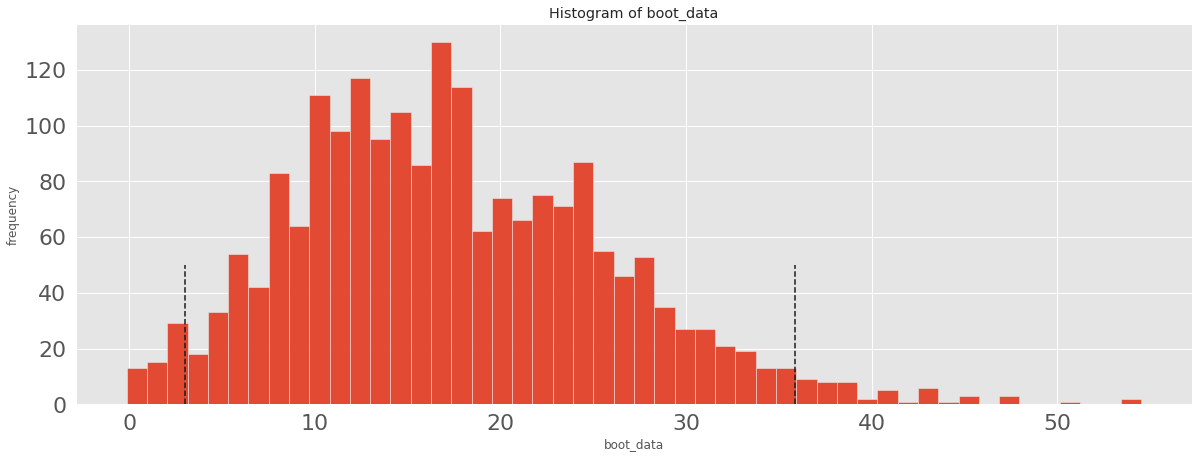

In [67]:
booted_data = get_bootstrap(test_data, control_data, boot_it = 2000)

Заметим, что p-value < 0.05

In [68]:
booted_data['p_value']

0.039866245557012465

А ноль не попадает в доверительный интервал

In [69]:
booted_data['ci']

,0
0.025,3.002015
0.975,35.869035


#### Так как 0 не попал в доверительный интервал и p-value оказалось меньше 0.05, то мы имеем основания отклонить нулевую гипотезу об отсутствии значимых различий между тестовой и контрольной группами. 
#### Стоит посмотреть на распределение медиан.

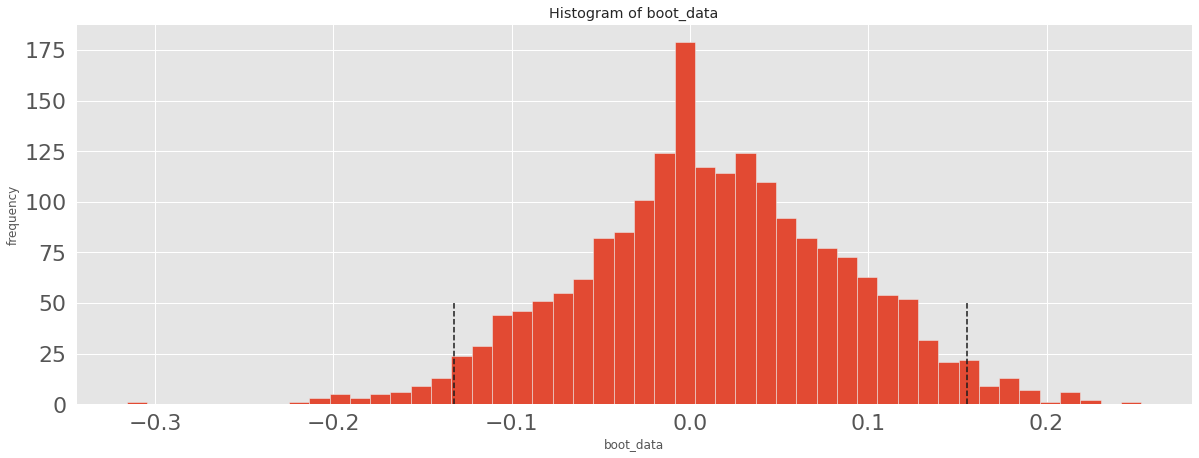

In [70]:
booted_data = get_bootstrap(test_data, control_data, boot_it = 2000, statistic=np.median)

А здесь уже p-value > 0.05

In [71]:
booted_data['p_value']

0.8711731749895499

И ноль в пределах доверительного интервала

In [72]:
booted_data['ci']

,0
0.025,-0.132132
0.975,0.155248


#### Здесь мы наблюдаем абсолютно противоположную ситуцию. Нет оснований отклонить нулевую гипотезу.
#### Уже понятно, что мы имеем дело с большими выбросами, наличие которых делает расчет среднего некорректным.

#### Стоит посмотреть на графики

Распределение контрольных значений

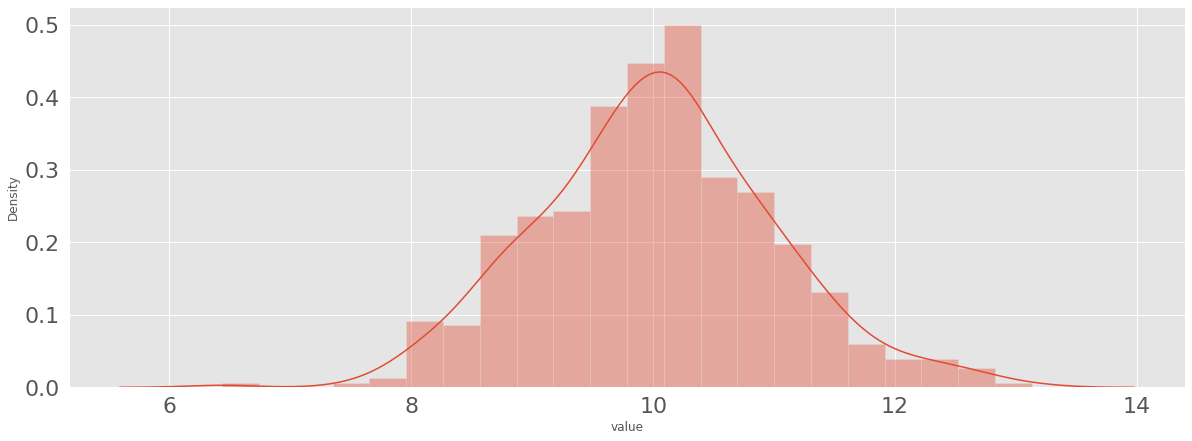

In [73]:
sns.distplot(control_data);

Распределение тестовых значений

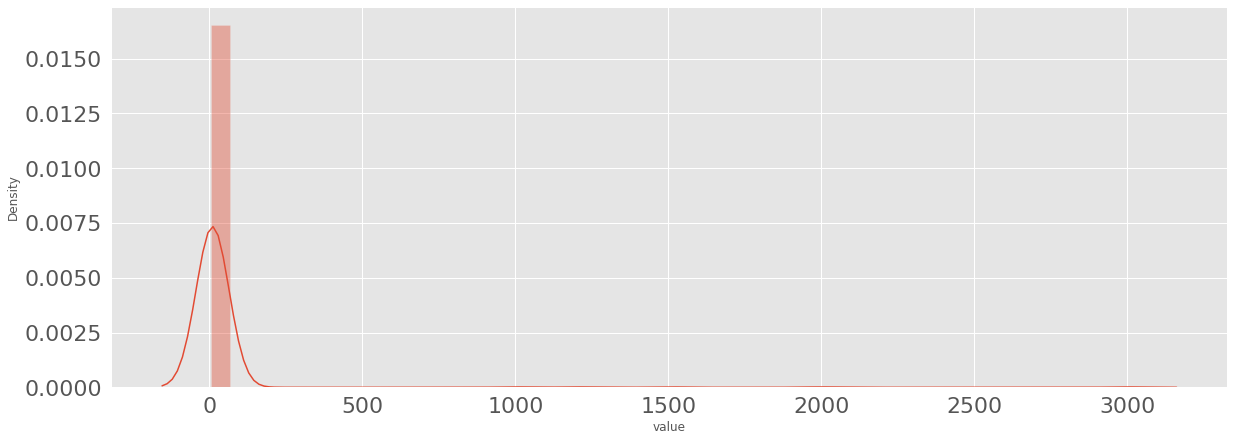

In [74]:
sns.distplot(test_data);

#### Заметим, что график распределения значений тестовой группы очень странный. Попробую 2 варианта: 
#### 1. Логарифмирование.
#### 2. Проверка на выбросы.

#### Посмотрим на логарифмированные распределение контрольных и тестовых значений

Контрольная группа

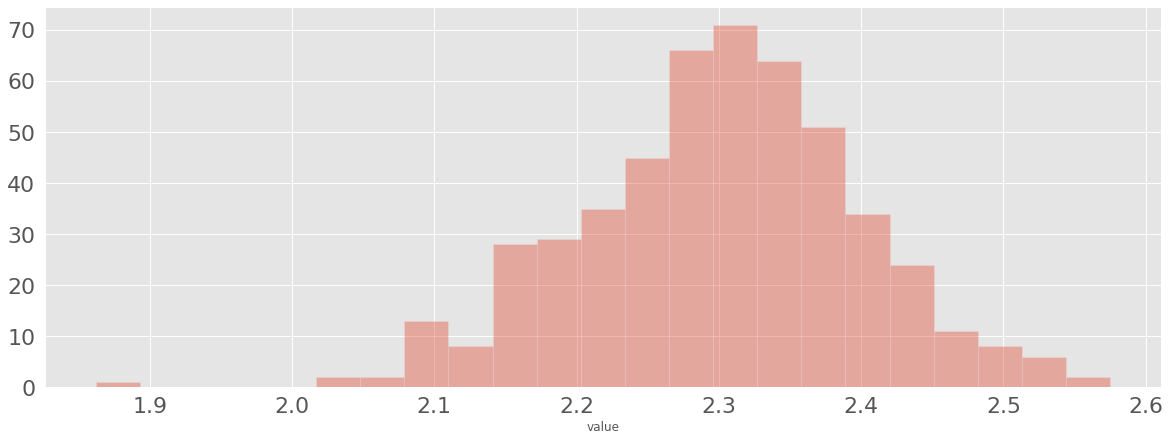

In [75]:
sns.distplot(np.log(control_data), kde=False);

Тестовая группа

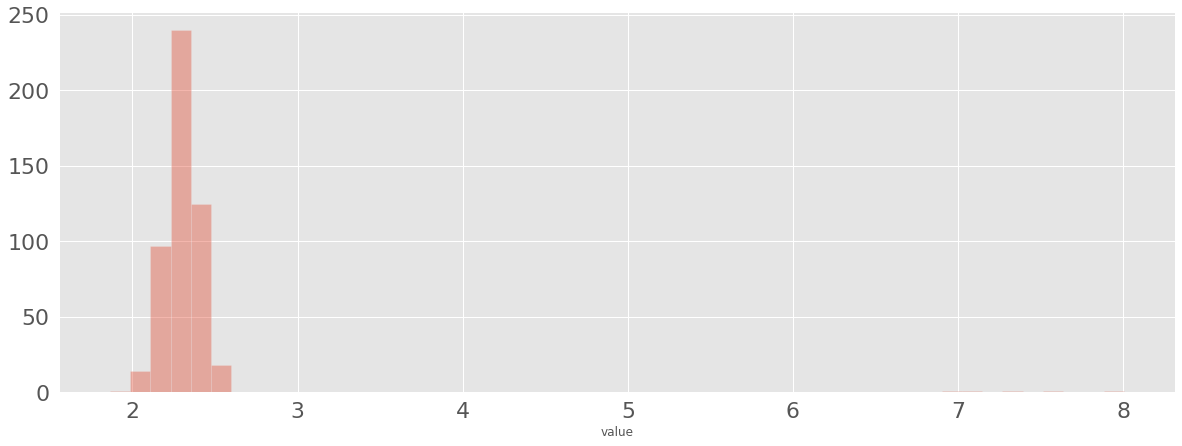

In [76]:
sns.distplot(np.log(test_data), kde=False);

Это выглядит лучше, но распределения кардинально различаются. 

Значит дело точно в больших выбросах.

Посчитаем среднее и медиану в каждой группе

In [77]:
print(f'Среднее в контрольной группе = {control_data.mean()} \nМедиана в контрольной группе = {control_data.median()}\n\nСреднее в тестовой группе = {test_data.mean()}\nМедиана в тестовой группе = {test_data.median()}')

Среднее в контрольной группе = 10.026866533804295 
Медиана в контрольной группе = 10.0184651909296

Среднее в тестовой группе = 27.321499056661573
Медиана в тестовой группе = 10.02584684253515


В тестовой группе имеется немаленькая разница между средним и медианой. Это говорит о том, что мы точно имеем дело с выбросами.

Попробуем найти эти выбросы

In [82]:
test_data.loc[test_data > 14]

996     1000.0
997     1200.0
998     1500.0
999     2000.0
1000    3000.0
Name: value, dtype: float64

#### Сделаем bootstrap, используя среднее по бут-выборкам после избавления от выбросов для подтверждения моего подозрения о том, что проблема была именно в них.

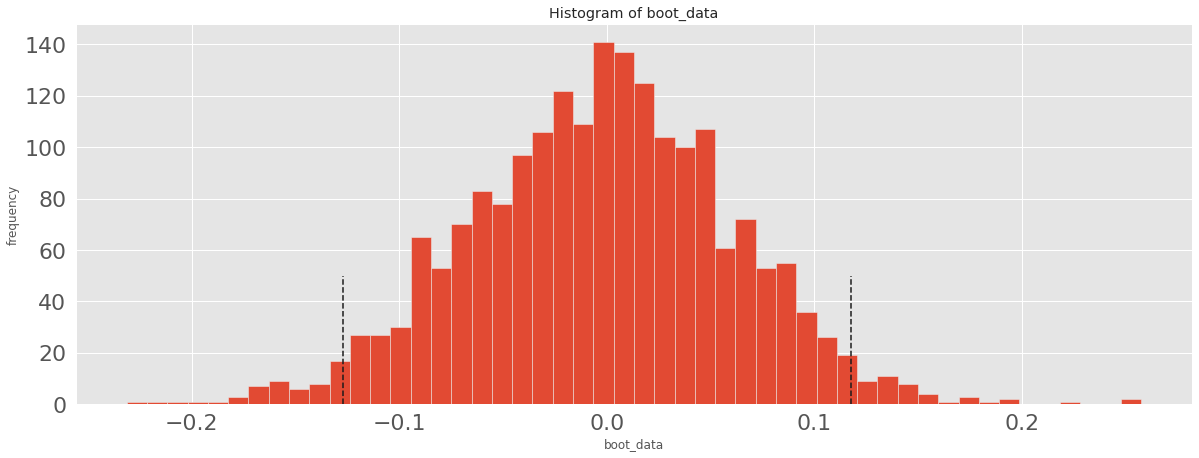

In [83]:
booted_data = get_bootstrap(test_data.loc[test_data < 14], control_data, boot_it = 2000)

Здесь p-value > 0.05

In [84]:
booted_data['p_value']

0.9636100053657064

И ноль в пределах доверительного интервала

In [85]:
booted_data['ci']

,0
0.025,-0.127122
0.975,0.117853


#### Вывод: 
В начале, используя критерий Манна-Уитни, мы заметили, что нулевую гипотезу о равенстве распределений в тестовой и контрольных группах мы отклонить не можем (ввиду p-value > 0.05). 

Далее я решил использовать bootstrap, с помощью которого мы можем проверить нулевую гипотезу о том, что статистика в тестовой и контрольной группах значимо различаются.

Первым делом в качестве статистики я использовал среднее, и мы получили значимые различия в двух группах. Это было странно с учетом результатов U-критерия о равенстве распределений. Было 2 варианта: либо различия действительно есть, либо проблема в данных (выбросы и т. д).

Далее я решил использовать медиану в качестве статистики, и получил абсолютно противоположные результаты. А также проверил результаты бутстрапа с использованием среднего, но уже исключив выбросы. Здесь мы получили аналогичный итог: значимых различий значениями тестовой и контрольной групп нет.